<a href="https://colab.research.google.com/github/Kanton99/QPU_NN_Project/blob/main/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quaternion Product Units for Deep Learning on 3D Rotation Groups

Student names : Anton Volkov (Matricola) & Keerthana Kumaresan (1998292)

The paper chosen is about using quaternion, quaternion algebra and the law of 3D rotation groups instead of Euclidean methods to create a mechanism to enhance the robustness of deep learning models to rotation. The proposed Quaternion Prouduct Unit represent the data as 3D pure quaternions (with the scalar being zero) and merges them through weighted chain of Hamilton products.

\begin{equation}
q= s + ix + jy +kz ⊂ \mathbb{H}
\end{equation}

where we have 1D real part and 3D imaginary part

 Such is used so we would be able to derive the "Rotation Invariant" and "Rotation Equivarient" features.

\begin{equation}
\mathbf{Rotation-invariance}: \space f(R(x)) = f(x), \forall x \in X \\
\mathbf{Rotation-eqivariance}: \space f(R(x)) = R(f(x)), \forall x \in X \\
\end{equation}

$x = [x_{1}, ...,x_{N}] \in X$ contains $N$ rotations. The above feature support and improve the efficency in theory. The suggested QPU is implemented in a quaternion neural network and is made compatible with existing  deep learning models.

## QPU

Each quaternion is represented as a unit quaternion, where the imaginary part gives the direction of its rotaion axis and the real part corresponds to the cosine of its rotation angle.

$q_{out} = [s_{out},v_{out}] \in \mathbb{H}$ where the outputs gives us the rotation invariant and eqivariant part.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=15XPVmukWbq1-_dwH_UeokPYvoAsY_9e5' width = 70%/>
</figure>

We represent the quaternion removing the imaginary parts.

\begin{equation}
q = [s, \mathbf{v}] = [s, (x,y,z)]
\end{equation}

The Hamilton product between two quaternions $q_{1} = [s_{1}, \mathbf{v_{1}}]$ and $q_{2} = [s_{2}, \mathbf{v_{2}}]$ is defined as

\begin{equation}
q_{1} ⊗ q_{2} = [s_{1}s_{2} - (\mathbf{v_{1}} \cdot \mathbf{v_{2}}), \mathbf{v_{q}} \times \mathbf{v_{2}} + s_{1}\mathbf{v_{2}} +  s_{2}\mathbf{v_{1}}]
\end{equation}

we must note that the hamilton product is not commutative, the the order of rotations matter when implementing it. If we rotate a 3D vector $\mathbf{v_{1}}$ to another 3D vector $\mathbf{v_{2}}$ and the rotation is with the axis $\mathbf{u}$ and angle $\theta$ then we define a unit quaternion as

\begin{equation}
q = [s, \mathbf{v}] = [cos\left(\frac{\theta}{2}\right),sin\left(\frac{\theta}{2}\right) \mathbf{u}]
\end{equation}

where $\lVert \mathbf{u} \rVert_{2} = 1$ and $s^2 + \lVert \mathbf{v} \rVert_{2}^2 = cos^2\left(\frac{\theta}{2}\right),sin^2\left(\frac{\theta}{2}\right) =1$. The vectors $\mathbf{v_{1}}$ and $\mathbf{v_{2}}$ as pure quaternions $[0, \mathbf{v_{1}}]$ and $[0, \mathbf{v_{2}}]$

\begin{equation}
q = [0, \mathbf{v_{2}}] = q \otimes [0, \mathbf{v_{1}}] \otimes q^*
\end{equation}

The $q^* = [0, \mathbf{-v}]$ is the conjugate of $q$.

The combination of rotation matrices can also be denoted as such with Hamilton products.

\begin{equation}
(q_{2} \otimes q_{1})  \otimes [0, \mathbf{v_{1}}] \otimes (q^*_1 \otimes q^*_2)
\end{equation}


In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

from components.functions import *


class QPU(nn.Module):
    """
    in_features: number of input data to each node
    out_features: number of nodes in the layer
    """
    #similar to QPU example github since needs same parameters
    def __init__(self, in_features, out_features):
        super(QPU, self).__init__()
        self.in_features = in_features // 4
        self.out_features = out_features // 4
        self.weights = Parameter(torch.Tensor(self.out_features,self.in_features))
        self.bias = Parameter(torch.Tensor(self.out_features))

        nn.init.xavier_uniform_(self.weights)
        if self.bias is not None:
            fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(self.weights)
            a = math.sqrt(6 / (fan_in + fan_out))
            nn.init.uniform_(self.bias, -a, a)


    def forward(self,x):
        return qpu_forward(x,self.weights,self.bias)

class AngelAxisMap(nn.Module):
    def __init__(self):
        super(AngelAxisMap,self).__init__()

    def forward(self,q):
        return angleAxisMap(q)

class KeepRealPart(nn.Module):
    def __init__(self) -> None:
        super(KeepRealPart,self).__init__()

    def forward(self,q: torch.Tensor):
        batch_size = q.shape[0]
        batch_elements = q.shape[-1]
        q = q.reshape((batch_size,batch_elements//4,4))
        q = q.permute(0,2,1)
        ret = torch.zeros(batch_size,batch_elements//4)
        for i in range(batch_size):
            ret[i] = q[i][0]
        return ret

ModuleNotFoundError: ignored

## FUNCTIONS

In [ ]:
import torch
import math

#quaternion are defined as a 4 element tesnor

def q_prod(q1:torch.Tensor,q2:torch.Tensor):
    q1_vector = torch.take(q1,torch.tensor([1,2,3]))
    q2_vector = torch.take(q2,torch.tensor([1,2,3]))
    q1_scalar = torch.take(q1,torch.tensor([0]))
    q2_scalar = torch.take(q2,torch.tensor([0]))
    scalar = q1_scalar*q2_scalar-torch.dot(q1_vector,q2_vector)
    vector = torch.cross(q1_vector,q2_vector)+torch.mul(q1[0],q2[1])+torch.mul(q2[0],q1[1])
    return torch.cat((scalar,vector))


def qpu_power(x,y,z,w,weights):
    wabs = torch.mul(weights,(torch.acos(x)))
    x = torch.cos(wabs)
    norms = torch.sqrt(y**2+z**2+w**2)
    mul = torch.sin(wabs)/norms
    y = y * mul
    z = z * mul
    w = w * mul
    return (x,y,z,w)

def bias_qpu_power(x,y,z,w,weights,b):
    theta = torch.acos(x)+b.unsqueeze(-1)

    wabs = weights*theta
    x = torch.cos(wabs)
    norms = torch.sqrt(y**2+z**2+w**2+1e-12)
    mul = torch.sin(wabs)/norms
    y = y * mul
    z = z * mul
    w = w * mul
    return (x,y,z,w)


#Similar to original function due to being the most efficient
def qpu_forward(inputs,weights,bias):
    """"""
    in_channels = inputs.shape[-1]//4
    out_channels = weights.shape[0]

    x,y,z,w = inputs.unsqueeze(-2).split(in_channels,dim=-1)

    x,y,z,w = bias_qpu_power(x,y,z,w,weights,bias)
    x,y,z,w = QuaternionRemoveZeros.apply(x,y,z,w)
    x,y,z,w = quaternion_chained_prod(x,y,z,w,-1)
    ret = torch.cat((x,y,z,w),dim=1)
    return ret

def quaternion_chained_prod_m(r_input, i_input, j_input, k_input, dim, last=None):
    batch_num = r_input.shape[0]
    r_prod = r_input.clone()
    i_prod = i_input.clone()
    j_prod = j_input.clone()
    k_prod = k_input.clone()
    r_out = torch.tensor((32,32))
    i_out = torch.tensor((32,32))
    j_out = torch.tensor((32,32))
    k_out = torch.tensor((32,32))
    for i in range(batch_num):
        for j in range(r_prod.shape[1]):
            s = r_prod[i][j][0]
            x = i_prod[i][j][0]
            y = j_prod[i][j][0]
            z = k_prod[i][j][0]
            mat = torch.tensor([[s,-x,-y,-z],
                                [x,s,z,-y],
                                [y,-z,s,x],
                                [z,y,-x,s]],requires_grad=True)
            for k in range(1,r_prod.shape[2]-1):
                s = r_prod[i][j][k]
                x = i_prod[i][j][k]
                y = j_prod[i][j][k]
                z = k_prod[i][j][k]
                mat2 = torch.tensor([[s,-x,-y,-z],
                                [x,s,z,-y],
                                [y,-z,s,x],
                                [z,y,-x,s]],requires_grad=True)
                mat = torch.matmul(mat,mat2)
            last = torch.tensor([r_prod[i][j][-1],i_prod[i][j][-1],j_prod[i][j][-1],k_prod[i][j][-1]])
            res = torch.matmul(mat,last)
            r_out[i][j] = res[0]
            i_out[i][j] = res[1]
            j_out[i][j] = res[2]
            k_out[i][j] = res[3]

    return r_out,i_out,j_out,k_out

# this function down to quaternion_chained_prod_grad are copied since they are the fastests implementation for chaining the hamiltonian product
# and our tried code was too slow
def quaternion_chained_prod(r_input, i_input, j_input, k_input, dim, last=None):
    """
    Chained quaternion product along a dimension (recursive)
    Hamilton product:
    a1 a2 - b1 b2 - c1 c2 - d1 d2
    + ( a1 b2 + b1 a2 + c1 d2 − d1 c2 ) i
    + ( a1 c2 − b1 d2 + c1 a2 + d1 b2 ) j
    + ( a1 d2 + b1 c2 − c1 b2 + d1 a2 ) k
    """
    channel = r_input.shape[dim]
    if channel == 1:
        return r_input.squeeze(dim), i_input.squeeze(dim), j_input.squeeze(dim), k_input.squeeze(dim)
    else:
        # Split into pair(0) and odd(1)
        r_out, i_out, j_out, k_out = r_input.unfold(dim, 2, 2), i_input.unfold(dim, 2, 2), j_input.unfold(dim, 2, 2), k_input.unfold(dim, 2, 2)
        r_pair, r_odd = r_out.select(-1, 0), r_out.select(-1, 1)
        i_pair, i_odd = i_out.select(-1, 0), i_out.select(-1, 1)
        j_pair, j_odd = j_out.select(-1, 0), j_out.select(-1, 1)
        k_pair, k_odd = k_out.select(-1, 0), k_out.select(-1, 1)
        # pair * odd
        r_out, i_out, j_out, k_out = hamilton_product_chunk(r_pair, i_pair, j_pair, k_pair, r_odd, i_odd, j_odd, k_odd)
        # Multiply last
        if channel % 2 == 1:
            last = (r_input.select(dim, -1), i_input.select(dim, -1), j_input.select(dim, -1), k_input.select(dim, -1))
        if r_out.shape[dim] % 2 == 1 and last is not None:
            r_out = torch.cat([r_out,last[0].unsqueeze(dim)],dim=dim)
            i_out = torch.cat([i_out,last[1].unsqueeze(dim)],dim=dim)
            j_out = torch.cat([j_out,last[2].unsqueeze(dim)],dim=dim)
            k_out = torch.cat([k_out,last[3].unsqueeze(dim)],dim=dim)
            last = None
        # Recursion
        r_out, i_out, j_out, k_out = quaternion_chained_prod(r_out, i_out, j_out, k_out, dim, last)
        return r_out, i_out, j_out, k_out

class QuaternionChainedProdFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_r, input_i, input_j, input_k, dim=-1):
        """
        Chained quaternion product along a dimension (for loop)
        Hamilton product:
        a1 a2 - b1 b2 - c1 c2 - d1 d2
        + ( a1 b2 + b1 a2 + c1 d2 − d1 c2 ) i
        + ( a1 c2 − b1 d2 + c1 a2 + d1 b2 ) j
        + ( a1 d2 + b1 c2 − c1 b2 + d1 a2 ) k
        """
        input_r, input_i, input_j, input_k = input_r.clone(), input_i.clone(), input_j.clone(), input_k.clone()
        cumprod_r, cumprod_i, cumprod_j, cumprod_k = quaternion_cumprod_(input_r, input_i, input_j, input_k, dim)
        ctx.save_for_backward(cumprod_r, cumprod_i, cumprod_j, cumprod_k)
        ctx.dim = dim
        return cumprod_r.select(dim, -1), cumprod_i.select(dim, -1), cumprod_j.select(dim, -1), cumprod_k.select(dim, -1)

    @staticmethod
    def backward(ctx, grad_output_r, grad_output_i, grad_output_j, grad_output_k):
        cumprod_r, cumprod_i, cumprod_j, cumprod_k, = ctx.saved_tensors  # L, *

        # Compute cumprod of left and right seq for each input, grads are stored in cumprod on the fly to save memory
        grad_chain_r, grad_chain_i, grad_chain_j, grad_chain_k = quaternion_chained_prod_grad_cumprod(cumprod_r, cumprod_i, cumprod_j, cumprod_k,
                                                                        grad_output_r, grad_output_i, grad_output_j, grad_output_k, dim=ctx.dim)

        return grad_chain_r, grad_chain_i, grad_chain_j, grad_chain_k, None

def hamilton_product_chunk(r1, i1, j1, k1, r2, i2, j2, k2):
    """
    Hamilton product
    a1 a2 - b1 b2 - c1 c2 - d1 d2
    + ( a1 b2 + b1 a2 + c1 d2 − d1 c2 ) i
    + ( a1 c2 − b1 d2 + c1 a2 + d1 b2 ) j
    + ( a1 d2 + b1 c2 − c1 b2 + d1 a2 ) k
    """
    r_out, i_out, j_out, k_out = r1 * r2 - i1 * i2 - j1 * j2 - k1 * k2, \
                                 r1 * i2 + i1 * r2 + j1 * k2 - k1 * j2, \
                                 r1 * j2 - i1 * k2 + j1 * r2 + k1 * i2, \
                                 r1 * k2 + i1 * j2 - j1 * i2 + k1 * r2
    return r_out, i_out, j_out, k_out

def quaternion_cumprod_(r, i, j, k, dim):
    """Cumpute quaternion cumpord (inplace)
    """
    seq_len = r.shape[dim]
    cumprod_r = r.split(1, dim)
    cumprod_i = i.split(1, dim)
    cumprod_j = j.split(1, dim)
    cumprod_k = k.split(1, dim)
    for n in range(1, seq_len):
        cr, ci, cj, ck = hamilton_product_chunk(cumprod_r[n - 1], cumprod_i[n - 1], cumprod_j[n - 1], cumprod_k[n - 1],
                                                cumprod_r[n], cumprod_i[n], cumprod_j[n], cumprod_k[n])
        cumprod_r[n].copy_(cr)
        cumprod_i[n].copy_(ci)
        cumprod_j[n].copy_(cj)
        cumprod_k[n].copy_(ck)
    return r, i, j, k

def quaternion_chained_prod_grad_cumprod(cumprod_r, cumprod_i, cumprod_j, cumprod_k, grad_output_r, grad_output_i, grad_output_j, grad_output_k, dim):
    """Compute grad of quaternion chained prod from cumprod
    Args:
        cumprod_*: *, N, *
        grad_output_*: *, *
    """
    seq_len = cumprod_r.shape[dim]
    # Split shares the origin memory
    grad_output_r = grad_output_r.unsqueeze(dim)
    grad_output_i = grad_output_i.unsqueeze(dim)
    grad_output_j = grad_output_j.unsqueeze(dim)
    grad_output_k = grad_output_k.unsqueeze(dim)

    rl = torch.ones_like(cumprod_r)
    rl.narrow(dim, 1, seq_len - 1).copy_(cumprod_r.narrow(dim, 0, seq_len - 1))
    il = torch.zeros_like(cumprod_i)
    il.narrow(dim, 1, seq_len - 1).copy_(cumprod_i.narrow(dim, 0, seq_len - 1))
    jl = torch.zeros_like(cumprod_j)
    jl.narrow(dim, 1, seq_len - 1).copy_(cumprod_j.narrow(dim, 0, seq_len - 1))
    kl = torch.zeros_like(cumprod_k)
    kl.narrow(dim, 1, seq_len - 1).copy_(cumprod_k.narrow(dim, 0, seq_len - 1))

    rr, ir, jr, kr =  hamilton_product_chunk(cumprod_r, -cumprod_i, -cumprod_j, -cumprod_k,
                                             cumprod_r.narrow(dim, seq_len - 1, 1), cumprod_i.narrow(dim, seq_len - 1, 1),
                                             cumprod_j.narrow(dim, seq_len - 1, 1), cumprod_k.narrow(dim, seq_len - 1, 1))

    grad_r, grad_i, grad_j, grad_k = quaternion_chained_prod_grad(rl, il, jl, kl, rr, ir, jr, kr,
                                                grad_output_r, grad_output_i, grad_output_j, grad_output_k)
    return grad_r, grad_i, grad_j, grad_k

def quaternion_chained_prod_grad(rl, il, jl, kl, rr, ir, jr, kr, grad_output_r, grad_output_i, grad_output_j, grad_output_k):
    grad_input_r = (   rl * rr - il * ir - jl * jr - kl * kr) * grad_output_r + \
                    (- ir * jl + il * jr + rr * kl + rl * kr) * grad_output_k + \
                    (  rr * jl + rl * jr + ir * kl - il * kr) * grad_output_j + \
                    (  rr * il + rl * ir - jr * kl + jl * kr) * grad_output_i

    grad_input_i = ( - rr * il - rl * ir - jr * kl + jl * kr) * grad_output_r + \
                    (- rr * jl + rl * jr - ir * kl - il * kr) * grad_output_k + \
                    (- ir * jl - il * jr + rr * kl - rl * kr) * grad_output_j + \
                    (  rl * rr - il * ir + jl * jr + kl * kr) * grad_output_i

    grad_input_j = ( - rr * jl - rl * jr + ir * kl - il * kr) * grad_output_r + \
                    (  rr * il - rl * ir - jr * kl - jl * kr) * grad_output_k + \
                    (  rl * rr + il * ir - jl * jr + kl * kr) * grad_output_j + \
                    (- ir * jl - il * jr - rr * kl + rl * kr) * grad_output_i

    grad_input_k = ( - ir * jl + il * jr - rr * kl - rl * kr) * grad_output_r + \
                    (  rl * rr + il * ir + jl * jr - kl * kr) * grad_output_k + \
                    (- rr * il + rl * ir - jr * kl - jl * kr) * grad_output_j + \
                    (  rr * jl - rl * jr - ir * kl - il * kr) * grad_output_i

    return grad_input_r, grad_input_i, grad_input_j, grad_input_k
#copied from original code due to being the best implementation
class QuaternionRemoveZeros(torch.autograd.Function):
    """Replace [0, 0, 0, 0] with [1, 0, 0, 0]
    """
    @staticmethod
    def forward(ctx,r,i,j,k):
        norm = r**2+ i**2+ j**2+ k**2
        index = norm == 0
        ctx.save_for_backward(index)
        r[index] = 1
        return r,i,j,k

    @staticmethod
    def backward(ctx,gr,gi,gj,gk):
        index, = ctx.saved_tensors
        gr[index] = 0
        gi[index] = 0
        gj[index] = 0
        gk[index] = 0
        return gr, gi, gj, gk

def normalize(q):
    magnitude = torch.linalg.norm(q)
    # q[0]/=magnitude
    # q[1]/=magnitude
    # q[2]/=magnitude
    q/=magnitude
    return q

def angleAxisMap(q):
    scalar = torch.acos(q[0])
    o_vec = torch.cat(q[1],q[2],q[3])
    n_vec = normalize(o_vec)
    return torch.cat(scalar,n_vec)



if __name__=="__main__":

    x = torch.Tensor([[1,1,1,1],[2,2,2,2]])
    y = torch.Tensor([1,1])
    print(x+y.unsqueeze(-1))


## MODELS

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1M6_beQ3FZhl5GOWJRUZuQpNo_e_uHDp9' width = 70%/>
</figure>


<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1lmSkoOiFs_epW09DQaGHxVPEJJ2C5b78' width = 70%/>
</figure>





In [ ]:
import torch
import torch.nn as nn

if __name__ == "__main__":
    import sys
    sys.path.append('.')
from  components.Layers import *

# Taken from paper's code in CubeEdge/models.py
class MLPBase(nn.Module):
    def __init__(self):
        super(MLPBase, self).__init__()

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 2, 1)
        x = x.reshape(batch_size, -1)
        #x = torch.flatten(x)
        return self.stack(x)

class RMLP(MLPBase):
    def __init__(self,num_data,num_cls):
        super(RMLP,self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(num_data*4,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,num_cls)
        )

    def forward(self,x):
        x = torch.flatten(x)
        return self.stack(x)

# QMLP_RInv = nn.Sequential(
#     QPU(7,128),
#     QPU(128,512),
#     KeepRealPart(),
#     nn.Linear()
# )

class QMLP(MLPBase):
    def __init__(self,num_data,num_cls):
        super(QMLP,self).__init__()

        self.stack = nn.Sequential(
            QPU(num_data*4,128),
            QPU(128,128),
            nn.Linear(128,num_cls)
        )

## UTILS FILE

In [ ]:
#imported file to make the data generation work

import numpy as np

def random_unit_quaternion():
    q = np.random.rand(4)
    q = (q - 0.5) * 2  # [-1, 1)
    norm = np.sqrt(np.sum(np.square(q)))
    if norm == 0.:
        return random_unit_quaternion()  # try again
    else:
        q = q / norm
        return q


def normalize(v):
    """Normalize a vector along last axis.
    Args:
        v: np.array(..., d)
    Return:
        v normalized: np.array(..., d)
    """
    return v / (np.linalg.norm(v, axis=-1, keepdims=True) + 1e-12)


def q_angle_axis(theta, axis):
    axis = axis / np.linalg.norm(axis) * np.sin(theta)
    return np.concatenate([[np.cos(theta)], axis])


def q_conj(q):
    """Compute quaternion conjugation
    Args:
        q: np.array(..., 4)
    Return:
        q_conj: np.array(..., 4)
    """
    return np.stack([q[..., 0], -q[..., 1], -q[..., 2], -q[..., 3]], axis=-1)


def q_power(q, h):
    if np.abs(q[0]) > 1. - 1e-6:
        return q
    theta = np.arccos(q[0])
    theta = theta * h
    q = q.copy()
    mul = np.sin(theta) / (np.sqrt(1 - q[0] * q[0]) + 1e-6)
    q[0] = np.cos(theta)
    q[1] = q[1] * mul
    q[2] = q[2] * mul
    q[3] = q[3] * mul
    return q


def q_geo_distance(q1, q2):
    return 1 - np.abs(np.sum(q1 * q2))


def q_angle(v1, v2):
    """Compute quaternion angle of shortest arc from vector v1 to v2.
    Args:
        v1: np.array(..., 3)
        v2: np.array(..., 3)
    Return:
        q: np.array(..., 4)
    References:
        https://bitbucket.org/sinbad/ogre/src/9db75e3ba05c/OgreMain/include/OgreVector3.h?fileviewer=file-view-default#cl-651
        https://stackoverflow.com/questions/1171849/finding-quaternion-representing-the-rotation-from-one-vector-to-another
    Formular
        q = 2|v1||v2|cos(phi)*(cos(phi) + mu*sin(phi))
    """
    v1 = normalize(v1)
    v2 = normalize(v2)
    q = np.repeat(np.zeros_like(v1[..., :1]), 4, axis=-1)
    dot = np.sum(v1 * v2, axis=-1)
    # Inverse vectors
    inv_ind = dot < (1e-6 - 1.)
    if np.sum(inv_ind) > 0:
        # Get an axis and rotate pi
        c = np.cross([1, 0, 0], v1[inv_ind])
        # If colinear, pick another axis
        col_ind = np.linalg.norm(c, axis=-1) < 1e-6
        c[col_ind] = np.cross([0, 1, 0], v1[inv_ind][col_ind])
        q[inv_ind] = np.concatenate([np.zeros_like(c[..., :1]), c], axis=-1)

    # Normal case
    norm_ind = ~inv_ind
    if np.sum(norm_ind) > 0:
        c = np.cross(v1[norm_ind], v2[norm_ind])  # 2 * mu * sin(phi) * cos(phi)
        s = np.sqrt((1 + dot[norm_ind]) * 2)  # 2 * |cos(phi)|
        s = np.expand_dims(s, axis=-1)
        q_xyz = c / s
        q_w = s / 2.
        q[norm_ind] = np.concatenate([q_w, q_xyz], axis=-1)

    # Handle when v1 or v2 is zero
    q = normalize(q)
    return q


def q_mul(q1, q2):
    """Compute Hamilton product between q1 and q2.
    Args:
        q1: np.array(..., 4)
        q2: np.array(..., 4)
    Return:
        q1xq2: (..., 4)
    """
    # Compute outer product
    r1, i1, j1, k1 = q1[..., 0], q1[..., 1], q1[..., 2], q1[..., 3]
    r2, i2, j2, k2 = q2[..., 0], q2[..., 1], q2[..., 2], q2[..., 3]

    r_out, i_out, j_out, k_out = r1 * r2 - i1 * i2 - j1 * j2 - k1 * k2, \
                                 r1 * i2 + i1 * r2 + j1 * k2 - k1 * j2, \
                                 r1 * j2 - i1 * k2 + j1 * r2 + k1 * i2, \
                                 r1 * k2 + i1 * j2 - j1 * i2 + k1 * r2

    return np.stack([r_out, i_out, j_out, k_out], axis=-1)


def q_rel_angle(v1, v2):
    """
    First move reference frame so that v1 = x with minimum rotation. Then compute quaternion angle from x to v2.
    Args:
        v1: np.array(..., 3)
        v2: np.array(..., 3)
    Return:
        q: np.array(..., 4)
    """
    x = np.zeros_like(v1)
    x[..., 0] = 1

    return q_mul(q_angle(v1, x), q_angle(x, v2))


def q_rotate(q, v):
    """
    Apply quaternion rotation q to v.
    Args:
        q: np.array(..., 4)
        v: np.array(..., 3)
    Return:
        v rotated: np.array(..., 3)
    """
    v = np.concatenate([np.zeros_like(v[..., :1]), v], axis=-1)  # 3D vector to pure quaternion
    return q_mul(q, q_mul(v, q_conj(q)))[..., 1:]


if __name__ == '__main__':
    # Tests for q_angle
    # Normal
    v1 = np.array([0, 0.1, 0])
    v2 = np.array([0.1, 0, 0])
    print('v1:', v1, 'v2:', v2)
    print('q_angle:', q_angle(v1 ,v2), 'expected: [0.707, 0, 0, -0.707]')
    print('-')
    # Same direction
    v1 = np.array([0.1, 0, 0])
    v2 = np.array([0.2, 0, 0])
    print('v1:', v1, 'v2:', v2)
    print('q_angle:', q_angle(v1, v2), 'expected: [1, 0, 0, 0]')
    print('-')
    # Inverse 1
    v1 = np.array([0.1, 0, 0])
    v2 = np.array([-0.1, 0, 0])
    print('v1:', v1, 'v2:', v2)
    print('q_angle:', q_angle(v1, v2), 'expected: [0, 0, 0, -1]')
    print('-')
    # Inverse 2
    v1 = np.array([0, 0.1, 0])
    v2 = np.array([0, -0.1, 0])
    print('v1:', v1, 'v2:', v2)
    print('q_angle:', q_angle(v1, v2), 'expected: [0, 0, 0, 1]')
    # Batched
    v1 = np.array([[0, 0.1, 0], [0, 0.1, 0]])
    v2 = np.array([[0.1, 0, 0], [0, -0.1, 0]])
    print('v1:', v1, 'v2:', v2)
    print('q_angle:', q_angle(v1, v2), 'expected: [[0.707, 0, 0, -0.707], [0, 0, 0, 1]]')

    # Tests for q_mul
    q1 = np.array([2.5, 5, -2.1, 2])
    q2 = np.array([1, 3, -6.1, 1])
    print('q1:', q1, 'q2:', q2)
    print('q_mul:', q_mul(q1, q2), 'expected: [-27.31, 22.6, -16.35, -19.7]')
    print('-')

    # Test for q_power
    q = random_unit_quaternion()
    q2 = q_power(q, -1)
    print('q', q, 'q^-1', q2)

v1: [0.  0.1 0. ] v2: [0.1 0.  0. ]
q_angle: [ 0.70710678  0.          0.         -0.70710678] expected: [0.707, 0, 0, -0.707]
-
v1: [0.1 0.  0. ] v2: [0.2 0.  0. ]
q_angle: [1. 0. 0. 0.] expected: [1, 0, 0, 0]
-
v1: [0.1 0.  0. ] v2: [-0.1  0.   0. ]
q_angle: [ 0.  0.  0. -1.] expected: [0, 0, 0, -1]
-
v1: [0.  0.1 0. ] v2: [ 0.  -0.1  0. ]
q_angle: [0. 0. 0. 1.] expected: [0, 0, 0, 1]
v1: [[0.  0.1 0. ]
 [0.  0.1 0. ]] v2: [[ 0.1  0.   0. ]
 [ 0.  -0.1  0. ]]
q_angle: [[ 0.70710678  0.          0.         -0.70710678]
 [ 0.          0.          0.          1.        ]] expected: [[0.707, 0, 0, -0.707], [0, 0, 0, 1]]
q1: [ 2.5  5.  -2.1  2. ] q2: [ 1.   3.  -6.1  1. ]
q_mul: [-27.31  22.6  -16.35 -19.7 ] expected: [-27.31, 22.6, -16.35, -19.7]
-
q [-0.19595618 -0.21998099 -0.33741106 -0.8940712 ] q^-1 [-0.19595618  0.21998077  0.33741072  0.89407029]


## DATASET GENERATION

### CUBE EDGE

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1-uN02rj6LpVbLVWzMlnPddkOEztP7Mas' width = 70%/>
</figure>



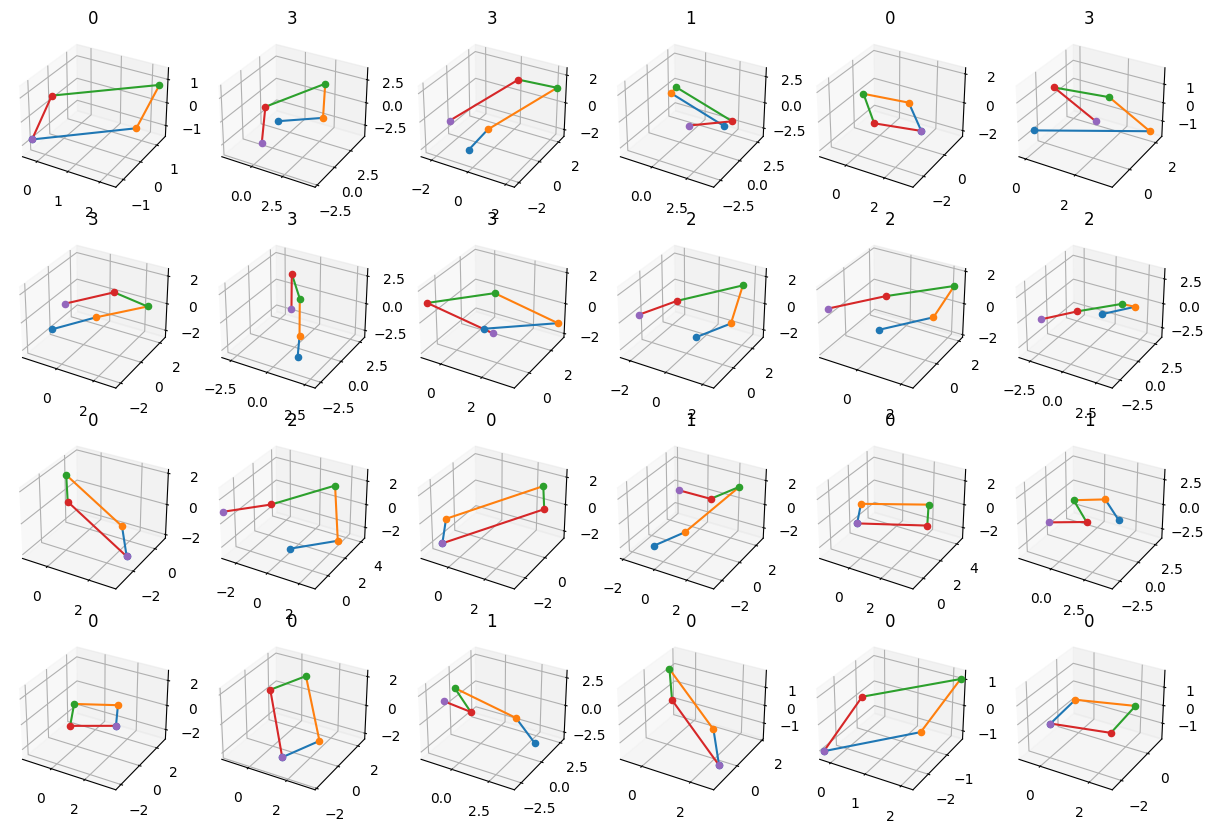

In [ ]:
#Taken from the paper's code to generate the datasets
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

if __name__ == "__main__":
    import sys
    sys.path.append('.')
#from utils.quaternion import q_angle, q_rotate

class CubeEdge(torch.utils.data.Dataset):
    """Generate CubeEgde dataset on the fly.
    1. Sample a cube.
    2. Add noise to vertices if training
    2. Apply random shear on xy plane
    Vertices ind :
      7----6
     /|   /|
    3----2 |
    | 4--|-5
    |/   |/
    0----1
    """
    def __init__(self, train, num_edges=4, num_samples=2000, use_quaternion=True, random_rotation=False, sigma=0.1):
        """
        Params:
            train: (bool) whether is training set
            num_edges: (int) number of edges
            num_samples: (int) number of samples
            use_quaternion: (bool) whether convert to quaternion
            random_rotation: (bool) whether apply random rotation
            sigma: (float) standard deviation of the noise applied to vertices
        """
        self.seed_is_set = False  # multi threaded loading
        self.num_samples = num_samples
        self.train = train
        self.use_quaternion = use_quaternion
        self.random_rotation = random_rotation
        self.sigma = sigma
        self.vertices = np.array([[1, 0, 0], [1, 1, 0], [1, 1, 1], [1, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1], [0, 0, 1]], dtype="float32") * 2 - 1.

        # All possible shapes
        if num_edges == 4:
            self.num_shapes = 4
            self.shapes = np.array([self._make_shape(0, 1, 2, 3, 0),
                                    self._make_shape(0, 1, 2, 3, 7),
                                    self._make_shape(0, 1, 2, 6, 7),
                                    self._make_shape(0, 1, 2, 6, 5)])
        elif num_edges == 5:
            self.num_shapes = 8
            self.shapes = np.array([self._make_shape(0, 1, 2, 3, 0, 1),
                                    self._make_shape(0, 1, 2, 3, 0, 4),
                                    self._make_shape(0, 1, 2, 3, 7, 4),
                                    self._make_shape(0, 1, 2, 3, 7, 6),
                                    self._make_shape(0, 1, 2, 6, 7, 4),
                                    self._make_shape(0, 1, 2, 6, 7, 3),
                                    self._make_shape(0, 1, 2, 6, 5, 4),
                                    self._make_shape(0, 1, 2, 6, 5, 1)])
        elif num_edges == 6:
            self.num_shapes = 16
            self.shapes = np.array([self._make_shape(0, 1, 2, 3, 0, 1, 2),
                                    self._make_shape(0, 1, 2, 3, 0, 1, 5),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 7),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 5),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 0),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 5),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 2),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 5),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 0),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 5),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 2),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 0),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 0),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 7),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 0),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 2)])

        elif num_edges == 7:
            self.num_shapes = 32
            self.shapes = np.array([self._make_shape(0, 1, 2, 3, 0, 1, 2, 3),
                                    self._make_shape(0, 1, 2, 3, 0, 1, 2, 6),
                                    self._make_shape(0, 1, 2, 3, 0, 1, 5, 4),
                                    self._make_shape(0, 1, 2, 3, 0, 1, 5, 6),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 7, 3),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 7, 6),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 5, 1),
                                    self._make_shape(0, 1, 2, 3, 0, 4, 5, 6),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 0, 1),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 0, 3),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 5, 1),
                                    self._make_shape(0, 1, 2, 3, 7, 4, 5, 6),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 2, 1),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 2, 3),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 5, 1),
                                    self._make_shape(0, 1, 2, 3, 7, 6, 5, 4),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 0, 1),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 0, 3),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 5, 1),
                                    self._make_shape(0, 1, 2, 6, 7, 4, 5, 6),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 2, 1),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 2, 6),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 0, 1),
                                    self._make_shape(0, 1, 2, 6, 7, 3, 0, 4),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 0, 1),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 0, 3),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 7, 3),
                                    self._make_shape(0, 1, 2, 6, 5, 4, 7, 6),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 0, 3),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 0, 4),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 2, 3),
                                    self._make_shape(0, 1, 2, 6, 5, 1, 2, 6)])

    def _make_shape(self, *vertice_ind):
        shape = []
        for ind in vertice_ind:
            shape.append(self.vertices[ind])
        return np.array(shape)

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        """
        Return:
            shape: (np.array) (num_edges + 1, 3) if use_quaternion=True,
                              (num_edges, 4) otherwise.
            shape_ind: (int) which shape is sampled
        """
        if self.train:
            self.set_seed(index)
        else:
            self.set_seed(index + self.num_samples)
        shape_ind = np.random.randint(self.num_shapes)
        shape = self.shapes[shape_ind]
        if not self.train:
            shape = self.add_noise(shape, self.sigma)
        shape = self.apply_random_shear(shape)
        if self.random_rotation:
            shape = self.apply_random_rotation(shape)
        if self.use_quaternion:
            shape = self.pos2qu(shape)
        return np.float32(shape), shape_ind

    @staticmethod
    def add_noise(shape, sigma):
        shape = shape.copy()
        for i in range(shape.shape[0]):
            shape[i] += np.random.randn(3) * sigma
        return shape

    @staticmethod
    def apply_random_shear(shape):
        """random shear on xy plane
        """
        shape = shape.copy()
        hxy, hxz, hyx, hyz, hzx, hzy = np.random.randn(6)
        # Keep axis z unchanged
        hzx = 0
        hzy = 0
        for i in range(shape.shape[0]):
            shape[i][0], shape[i][1], shape[i][2] = shape[i][0] + hxy * shape[i][1] + hxz * shape[i][2], \
                                                    shape[i][1] + hyx * shape[i][0] + hyz * shape[i][2], \
                                                    shape[i][2] + hzx * shape[i][0] + hzy * shape[i][1]
        return shape

    @staticmethod
    def apply_random_rotation(shape):
        shape = shape.copy()
        angle_x, angle_y, angle_z = np.random.rand(3) * 2 * np.pi
        for i in range(shape.shape[0]):
            # x roll
            shape[i][1], shape[i][2] = np.cos(angle_x) * shape[i][1] - np.sin(angle_x) * shape[i][2], \
                                       np.sin(angle_x) * shape[i][1] + np.cos(angle_x) * shape[i][2]
            # y roll
            shape[i][0], shape[i][2] = np.cos(angle_y) * shape[i][0] - np.sin(angle_y) * shape[i][2], \
                                       np.sin(angle_y) * shape[i][0] + np.cos(angle_y) * shape[i][2]
            # z roll
            shape[i][0], shape[i][1] = np.cos(angle_z) * shape[i][0] - np.sin(angle_z) * shape[i][1], \
                                       np.sin(angle_z) * shape[i][0] + np.cos(angle_z) * shape[i][1]
        return shape

    @staticmethod
    def pos2qu(shape):
        """Convert 3D coordinates to quaternion rotation
        """
        num_vertices = shape.shape[0]
        q_shape = np.zeros([num_vertices - 1, 4])
        q_shape[0] = q_angle(shape[1] - shape[0], shape[1] - shape[0])
        for i in range(1, num_vertices - 1):
            q_shape[i] = q_angle(shape[i - 1] - shape[i], shape[i + 1] - shape[i])
        return q_shape

    @staticmethod
    def plot_cube(ax, shape, name):
        for i in range(shape.shape[0]):
            ax.scatter(shape[i][0], shape[i][1], shape[i][2], marker='o')
        for i in range(shape.shape[0] - 1):
            ax.plot([shape[i][0], shape[i + 1][0]], [shape[i][1], shape[i + 1][1]], [shape[i][2], shape[i + 1][2]])
        ax.set_title(name)
        x_max, x_min = np.max(shape[:, 0]), np.min(shape[:, 0])
        y_max, y_min = np.max(shape[:, 1]), np.min(shape[:, 1])
        z_max, z_min = np.max(shape[:, 2]), np.min(shape[:, 2])
        max_range = np.max([x_max - x_min, y_max - y_min, z_max - z_min]) / 2.0
        mid_x = (x_max + x_min) / 2.0
        mid_y = (y_max + y_min) / 2.0
        mid_z = (z_max + z_min) / 2.0
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)


if __name__ == "__main__":
    cube_edges = CubeEdge(train=True, num_edges=4, use_quaternion=False)
    rows = 4
    cols = 6
    imsize = 2.5
    fig = plt.figure('samples', figsize=(imsize * cols, imsize * rows))
    for i in range(rows * cols):
        shape, label = cube_edges[i]
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
        CubeEdge.plot_cube(ax, shape, label)
    plt.show()

## TRAIN AND TEST

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time

if __name__ == "__main__":
    import sys
    sys.path.append('.')
from models import *
from cubeEdgeData import CubeEdge

device = (
        "cuda" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
def train(model,data,epochs,lr,batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

    train_dataloader = DataLoader(data,batch_size=batch_size,shuffle=True)
    loss = 0
    net.to(device=device)
    for epoch in range(epochs):
        net.train()
        #Forward pass
        for input,label in train_dataloader:
            input.to(device)
            label.to(device)
            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs,label)
            loss.backward()
            optimizer.step()

        if ((epoch+1) % 10) == 0:
            print(f"epoch: {epoch+1}")
            print(loss)

def test(data, model):
    dataloader = DataLoader(data,batch_size=32,shuffle=True)
    loss_fn = nn.CrossEntropyLoss()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

if __name__=="__main__":

    start_time = time.time()
    training_data = CubeEdge(train=True, num_edges=7, use_quaternion=True,num_samples=500)
    test_data = CubeEdge(train=False,num_edges=7,use_quaternion=True,num_samples=50)
    net = QMLP_RInv(num_data=7,num_cls=training_data.num_shapes)
    train(model=net,data=training_data,epochs=100,lr=0.01,batch_size=training_data.num_shapes)
    test(model=net,data=test_data)
    print("--- %s seconds ---" % (time.time() - start_time))
    #print(rmlp_net(torch.tensor(data[0][0])))

